<table class="table table-bordered">
    <tr>
        <th style="width:200px;">
            <img src='https://bcgriseacademy.com/hs-fs/hubfs/RISE%202.0%20Logo_Options_25Jan23_RISE%20-%20For%20Black%20Background.png?width=3522&height=1986&name=RISE%202.0%20Logo_Options_25Jan23_RISE%20-%20For%20Black%20Background.png' style="background-color:black; width: 100%; height: 100%;">
        </th>
        <th style="text-align:center;">
            <h1>RISE2.0 Business and Data Analytics</h1>
            <h2>IU 3.7.2.1 Machine Learning Project</h2>
            <h3>Business Case 2 - Unsupervised Learning</h3>
        </th>
    </tr>
</table>

## Context

You are a data analyst working in a retail bank based in the Middle East, where they have been doing traditional mass marketing campaigns for years. The bank is now keen to explore the benefits of running tailored marketing campaigns for their customer base.

## Business problem

The retail bank is facing a couple of challenges:
1. Profitability pressure from reduced utilization by existing customers
2. Increasingly competitive landscape where other banks are running personalized ad campaigns using differentiated products and services

## Project objectives and description

In this discovery phase, the objective is to understand the various segments that exist in the bank's customer base, based on the customers' demographics and utilization patterns.

## Dataset

You are provided with the following files:
1. bank_customers.csv
2. Data Dictionary - Bank Customers.xlsx
___

## Step 1: Initial Setup

In [1]:
# Import the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### 1.1 Read the raw CSV file from the Data folder into pandas.

In [2]:
# Import bank customers dataset
df = pd.read_csv('Data/bank_customers.csv')

#### 1.2 View the first 5 rows of the data.

In [3]:
# Print first 5 rows
df.head()

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance
0,353446,INDIA,67,17/08/2017,Active,No Salary,No DR,No Bill,No CC,1820.582258
1,99061,PHILIPPINES,71,13/11/2020,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387
2,344207,GREECE,56,8/11/2018,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000
3,496773,GHANA,40,16/07/2019,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000
4,39530,PHILIPPINES,57,25/11/2017,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839


In [4]:
# Print last 5 rows
df.tail()

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance
995,66965,INDIA,57,2/01/2020,Active,Salary with Other Bank,Active DR,No Bill,Active CC,205.337742
996,152560,INDIA,22,8/02/2018,Active,Salary with Other Bank,No DR,Active Bill,No CC,0.000000
997,268132,INDIA,44,15/06/2019,Inactive,Salary with Other Bank,No DR,Inactive Bill,Active CC,11.649032
998,79628,INDIA,68,8/11/2020,Inactive,No Salary,Active DR,Active Bill,No CC,0.000000
999,240676,PHILIPPINES,35,1/12/2017,Inactive,No Salary,Inactive DR,No Bill,No CC,0.000000


___
## Step 2: Data Exploration [5 marks]

#### 2.1 Find the shape and data types of the dataset

In [5]:
# Check shape
df.shape

(1000, 10)

In [6]:
# Check dtypes
df.dtypes

Customer No                  int64
Customer Nationality        object
Customer Age                 int64
Account Opening Date        object
DC Spends                   object
SALARY_FLAG                 object
DR_FLAG                     object
Bill Payment                object
CC Spends                   object
Monthly Average Balance    float64
dtype: object

#### 2.2 Convert the columns to the appropriate data types (wherever necessary).
- HINT: Review date related columns

In [7]:
# Convert Account Opening Date to datetime
df['Account Opening Date'] = pd.to_datetime(df['Account Opening Date'], format='%d/%m/%Y')

#### 2.3 Check if there are any null values in the columns.

In [8]:
# Check for null values
print(df.isnull().sum().sum())

0


#### 2.4 For each categorical column, count the number of unique categories.
- HINT: Instead of doing it one by one, filter by dtypes that are equal to object, and print the unique count using `.nunique()`

In [9]:
# Filter columns with dtype 'object'
categorical_columns = df.select_dtypes(include=['object'])

# Count unique categories for each column
for col in categorical_columns.columns:
    unique_count = categorical_columns[col].nunique()
    print(f"Column '{col}': {unique_count} unique categories")


Column 'Customer Nationality': 62 unique categories
Column 'DC Spends': 3 unique categories
Column 'SALARY_FLAG': 3 unique categories
Column 'DR_FLAG': 3 unique categories
Column 'Bill Payment': 3 unique categories
Column 'CC Spends': 3 unique categories


#### 2.5 For numerical columns, check the data distributions using appropriate functions and plots (e.g., box plots).

In [10]:
# Generate statistical summary
summary = df[['Customer Age', 'Monthly Average Balance']].describe()
summary

,Customer Age,Monthly Average Balance
count,1000.000000,1000.000000
mean,49.540000,3263.444533
std,16.328534,17576.061302
min,21.000000,-27.500000
25%,36.000000,0.000000
50%,50.000000,15.750000
75%,64.000000,908.245968
max,77.000000,372334.503500


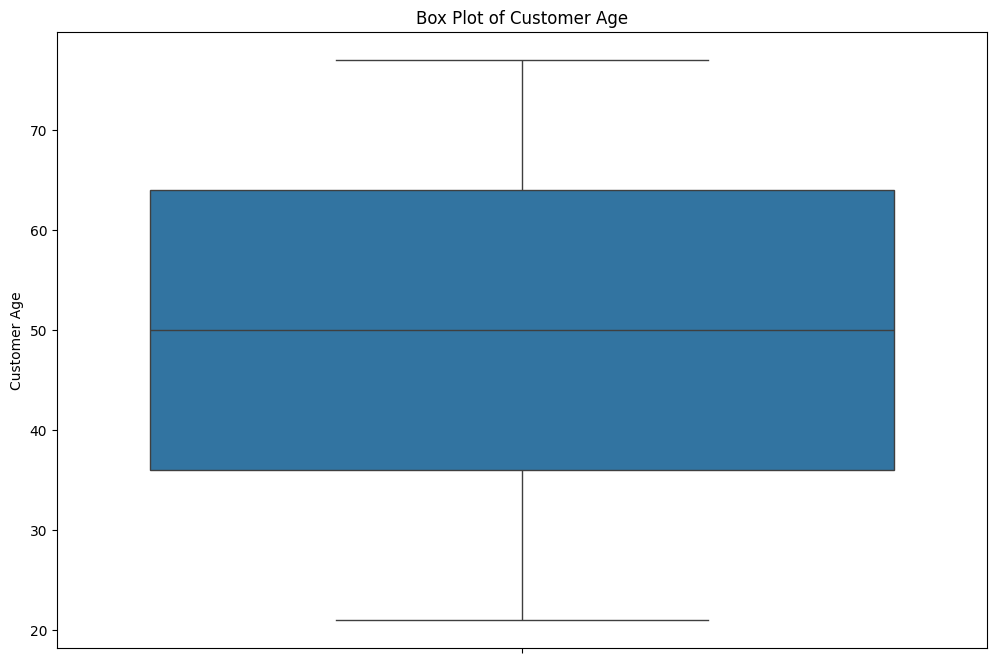

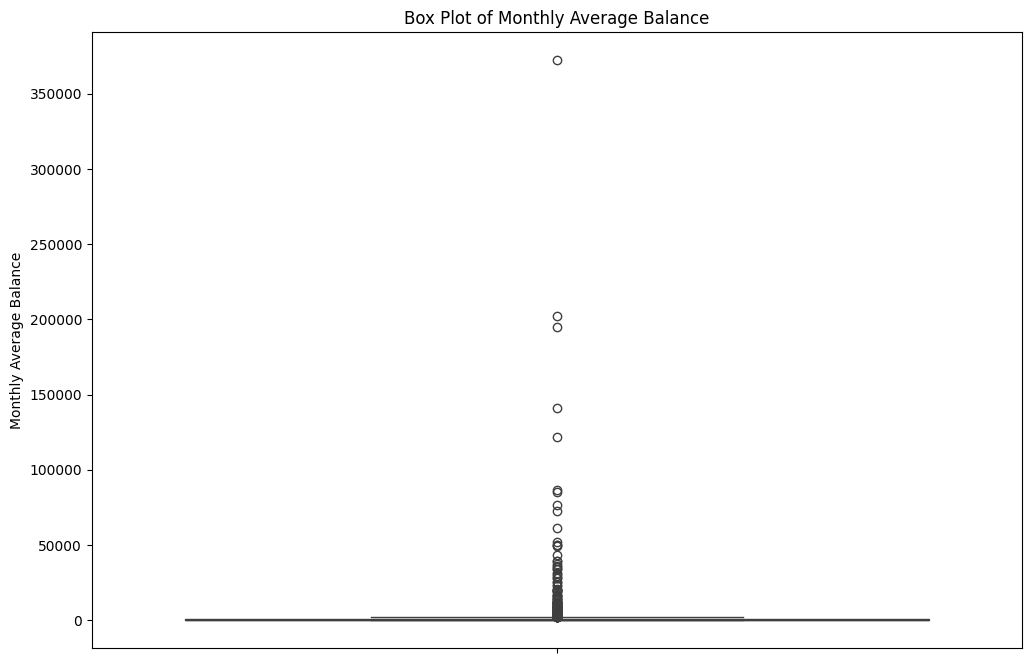

In [11]:
# Box plot for Customer Age
plt.figure(figsize=(12, 8))
sns.boxplot(y=df['Customer Age'])
plt.title('Box Plot of Customer Age')
plt.show()

# Box plot for Monthly Average Balance
plt.figure(figsize=(12, 8))
sns.boxplot(y=df['Monthly Average Balance'])
plt.title('Box Plot of Monthly Average Balance')
plt.show()

**Note**
- For this dataset, there are a few very large values (outliers) in the monthly average balance.
- Instead of dropping outliers, we will convert them into categories in the next step. 
- Note that dropping outliers is a bad move if we do not know exactly what is going on. For bank accounts, there will definitely be outliers because some customers are more wealthy than the rest. These are not data errors, so they should not be dropped just because they are 'inconvenient' for our analysis.

___
## Step 3: Data preprocessing [12 marks]

The goal here is to convert all values to numerical so that record of each customer will be in the form of numeric feature vectors

#### 3.1 Create a new column `Tenure` for the number of months (rounded to nearest integer) since the customer has opened the account.
- HINT: The snapshot date is 01 Mar 2022, so you should find the date difference between the snapshot date and the account opening date.

In [12]:
# Snapshot date (as of 01 Mar 2022)
snapshot_date = datetime(2022, 3, 1)

# Calculate tenure in months (rounded to nearest integer)
df['Tenure'] = ((snapshot_date - df['Account Opening Date']) / pd.Timedelta(days=30.4375)).astype(int)

# View the resulting dataframe
df

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance,Tenure
0,353446,INDIA,67,2017-08-17,Active,No Salary,No DR,No Bill,No CC,1820.582258,54
1,99061,PHILIPPINES,71,2020-11-13,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387,15
2,344207,GREECE,56,2018-11-08,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000,39
3,496773,GHANA,40,2019-07-16,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000,31
4,39530,PHILIPPINES,57,2017-11-25,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839,51
...,...,...,...,...,...,...,...,...,...,...,...
995,66965,INDIA,57,2020-01-02,Active,Salary with Other Bank,Active DR,No Bill,Active CC,205.337742,25
996,152560,INDIA,22,2018-02-08,Active,Salary with Other Bank,No DR,Active Bill,No CC,0.000000,48
997,268132,INDIA,44,2019-06-15,Inactive,Salary with Other Bank,No DR,Inactive Bill,Active CC,11.649032,32
998,79628,INDIA,68,2020-11-08,Inactive,No Salary,Active DR,Active Bill,No CC,0.000000,15


#### 3.2 Clean the `Monthly Average Balance` column by converting all negative balance values to 0.

In [13]:
# Convert negative balances to 0
df['Monthly Average Balance'] = df['Monthly Average Balance'].apply(lambda x: max(0, x))

# View the resulting dataframe
df

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance,Tenure
0,353446,INDIA,67,2017-08-17,Active,No Salary,No DR,No Bill,No CC,1820.582258,54
1,99061,PHILIPPINES,71,2020-11-13,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387,15
2,344207,GREECE,56,2018-11-08,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000,39
3,496773,GHANA,40,2019-07-16,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000,31
4,39530,PHILIPPINES,57,2017-11-25,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839,51
...,...,...,...,...,...,...,...,...,...,...,...
995,66965,INDIA,57,2020-01-02,Active,Salary with Other Bank,Active DR,No Bill,Active CC,205.337742,25
996,152560,INDIA,22,2018-02-08,Active,Salary with Other Bank,No DR,Active Bill,No CC,0.000000,48
997,268132,INDIA,44,2019-06-15,Inactive,Salary with Other Bank,No DR,Inactive Bill,Active CC,11.649032,32
998,79628,INDIA,68,2020-11-08,Inactive,No Salary,Active DR,Active Bill,No CC,0.000000,15


#### 3.3 Rather than discarding outliers, we want to group customers into the following categories based on the following monthly average balance deciles. 

- $\ge$95%: 'Very High'
- $\ge$80% - 95%: 'High'
- $\ge$50% - 80%: 'Middle'
- $\lt$50%: 'Normal'

#### Create Python variables to store these decile cutoffs.
- HINT: Only need to create 3 variables to indicate Very High, High, and Middle. Use the `.quantile` method

In [14]:
# Calculate quantiles
quantiles = df['Monthly Average Balance'].quantile([0.5, 0.8, 0.95])

# Assign decile cutoffs to variables
middle_cutoff = quantiles[0.5]
high_cutoff = quantiles[0.8]
very_high_cutoff = quantiles[0.95]

# Print decile cutoffs
print("Middle Cutoff:", middle_cutoff)
print("High Cutoff:", high_cutoff)
print("Very High Cutoff:", very_high_cutoff)

Middle Cutoff: 15.75
High Cutoff: 1718.8415486000035
Very High Cutoff: 12083.372146999995


#### 3.4 Using the decile cutoff variables above, create a new column called `Balance Level` by splitting the `Monthly Average Balance` column into 4 categories and giving them the corresponding integer labels: 1, 2, 3, 4 (where 4 corresponds to the very high balance category).
- HINT: Refer to https://stackoverflow.com/questions/44314670/create-rename-categories-with-pandas on how to use `pd.cut`. For the `bins` parameter, suggest to see the lowest value as -0.01 and highest value as 99999999

In [15]:
# Create bins for pd.cut()
bins = [-0.01, middle_cutoff, high_cutoff, very_high_cutoff, 99999999]

# Create labels for the bins
labels = [1, 2, 3, 4]

# Create Balance Level column using pd.cut()
df['Balance Level'] = pd.cut(df['Monthly Average Balance'], bins=bins, labels=labels, include_lowest=True)

# Convert labels to integers
df['Balance Level'] = df['Balance Level'].astype(int)

# Display the updated DataFrame
df

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance,Tenure,Balance Level
0,353446,INDIA,67,2017-08-17,Active,No Salary,No DR,No Bill,No CC,1820.582258,54,3
1,99061,PHILIPPINES,71,2020-11-13,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387,15,2
2,344207,GREECE,56,2018-11-08,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000,39,3
3,496773,GHANA,40,2019-07-16,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000,31,1
4,39530,PHILIPPINES,57,2017-11-25,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839,51,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,66965,INDIA,57,2020-01-02,Active,Salary with Other Bank,Active DR,No Bill,Active CC,205.337742,25,2
996,152560,INDIA,22,2018-02-08,Active,Salary with Other Bank,No DR,Active Bill,No CC,0.000000,48,1
997,268132,INDIA,44,2019-06-15,Inactive,Salary with Other Bank,No DR,Inactive Bill,Active CC,11.649032,32,1
998,79628,INDIA,68,2020-11-08,Inactive,No Salary,Active DR,Active Bill,No CC,0.000000,15,1


#### 3.5 For categorical columns, convert them to numeric format.
- Hint: use pandas dummy encoding 

In [16]:
# Convert categorical columns to dummy variables
categorical_columns = ['Customer Nationality', 'DC Spends', 'SALARY_FLAG', 
                       'DR_FLAG', 'Bill Payment', 'CC Spends']

# Use pd.get_dummies() for dummy encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=int)

# Display the updated DataFrame
df_encoded

,Customer No,Customer Age,Account Opening Date,Monthly Average Balance,Tenure,Balance Level,Customer Nationality_ALBANIA,Customer Nationality_ALGERIA,Customer Nationality_AUSTRALIA,Customer Nationality_BANGLADESH,...,DC Spends_Inactive,DC Spends_No Spends,SALARY_FLAG_Salary with Bank,SALARY_FLAG_Salary with Other Bank,DR_FLAG_Inactive DR,DR_FLAG_No DR,Bill Payment_Inactive Bill,Bill Payment_No Bill,CC Spends_Inactive CC,CC Spends_No CC
0,353446,67,2017-08-17,1820.582258,54,3,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,99061,71,2020-11-13,94.028387,15,2,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
2,344207,56,2018-11-08,5020.710000,39,3,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
3,496773,40,2019-07-16,0.000000,31,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,39530,57,2017-11-25,196.214839,51,2,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,66965,57,2020-01-02,205.337742,25,2,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
996,152560,22,2018-02-08,0.000000,48,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
997,268132,44,2019-06-15,11.649032,32,1,0,0,0,0,...,1,0,0,1,0,1,1,0,0,0
998,79628,68,2020-11-08,0.000000,15,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


#### 3.6 Drop columns that are no longer informative for downstream clustering.
- `Customer No`, `Customer Nationality`, `Account Opening Date`, `Monthly Average Balance`

In [17]:
# Drop columns that are no longer informative for clustering
columns_to_drop = ['Customer No', 'Account Opening Date', 'Monthly Average Balance']
df_encoded.drop(columns=columns_to_drop, inplace=True)

# Display the updated DataFrame
df_encoded.head()

,Customer Age,Tenure,Balance Level,Customer Nationality_ALBANIA,Customer Nationality_ALGERIA,Customer Nationality_AUSTRALIA,Customer Nationality_BANGLADESH,Customer Nationality_BELGIUM,Customer Nationality_BOSNIA & HERZEGOVINA,Customer Nationality_BULGARIA,...,DC Spends_Inactive,DC Spends_No Spends,SALARY_FLAG_Salary with Bank,SALARY_FLAG_Salary with Other Bank,DR_FLAG_Inactive DR,DR_FLAG_No DR,Bill Payment_Inactive Bill,Bill Payment_No Bill,CC Spends_Inactive CC,CC Spends_No CC
0,67,54,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,71,15,2,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
2,56,39,3,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
3,40,31,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,57,51,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


#### 3.6 Standardize the numerical values in the dataset.
Note: Perform min max scaling

In [18]:
# Initialize MinMaxScaler object
scaler = MinMaxScaler()

# Define columns to scale
columns_to_scale = ['Customer Age', 'Tenure']

# Apply MinMax scaling to selected columns in df_encoded DataFrame
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])

# Display the updated DataFrame
df_encoded

,Customer Age,Tenure,Balance Level,Customer Nationality_ALBANIA,Customer Nationality_ALGERIA,Customer Nationality_AUSTRALIA,Customer Nationality_BANGLADESH,Customer Nationality_BELGIUM,Customer Nationality_BOSNIA & HERZEGOVINA,Customer Nationality_BULGARIA,...,DC Spends_Inactive,DC Spends_No Spends,SALARY_FLAG_Salary with Bank,SALARY_FLAG_Salary with Other Bank,DR_FLAG_Inactive DR,DR_FLAG_No DR,Bill Payment_Inactive Bill,Bill Payment_No Bill,CC Spends_Inactive CC,CC Spends_No CC
0,0.821429,0.900000,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,0.892857,0.250000,2,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
2,0.625000,0.650000,3,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
3,0.339286,0.516667,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0.642857,0.850000,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.642857,0.416667,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
996,0.017857,0.800000,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
997,0.410714,0.533333,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,0,0,0
998,0.839286,0.250000,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


___
## Step 4: K-Means Clustering [12 marks]
#### The objective is to:
- Find the most appropriate k value using the Elbow method
- Calculate and store the silhouette coefficient values

#### 4.1 Create a baseline k-means model with `k=3` and `random_state=0` by fitting on the scaled data.

In [19]:
# Initialize KMeans object with k=3 and random_state=0
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit KMeans model to the scaled data
kmeans.fit(df_encoded)

# Retrieve cluster labels assigned to each data point
cluster_labels = kmeans.labels_

# Print cluster labels
print("Cluster Labels:", cluster_labels)

Cluster Labels: [0 2 0 1 1 2 2 2 0 1 2 0 2 0 1 0 0 2 1 2 2 1 1 1 1 1 2 1 1 1 1 0 2 0 2 1 1
 2 1 0 1 1 2 2 0 1 1 2 1 0 0 1 2 0 1 1 1 0 0 0 0 0 2 1 1 2 1 1 1 1 2 1 1 1
 0 0 2 1 2 1 2 1 2 1 2 1 1 1 1 1 2 0 1 2 1 1 2 2 1 0 1 2 1 1 1 1 1 1 1 0 2
 2 1 0 1 1 2 2 2 1 2 0 0 1 0 1 2 2 1 0 1 1 2 1 2 1 1 2 2 0 1 1 2 2 2 1 2 0
 1 2 2 1 1 2 1 2 1 2 2 1 0 1 0 2 2 1 1 2 1 1 1 1 1 1 1 2 1 0 1 0 2 1 2 1 1
 0 1 2 2 0 1 2 0 1 0 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 2 0 1 1 1 2 0 1 2 1 2 1
 1 2 2 2 0 0 1 1 1 1 2 2 1 2 1 1 2 1 1 0 1 1 1 1 1 0 2 1 2 1 1 2 0 1 2 0 0
 1 1 1 2 1 2 1 2 0 1 1 1 1 1 1 1 0 2 1 1 1 2 1 0 1 0 2 2 1 1 1 0 2 2 1 0 0
 1 0 1 1 1 1 1 2 1 1 1 2 2 1 1 0 0 1 2 1 1 1 1 2 1 0 0 1 1 2 1 1 1 0 1 2 2
 1 1 1 1 0 0 1 1 0 2 1 1 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 2 1 2 2 0 1 2
 0 0 1 2 2 1 1 1 2 1 1 1 1 0 1 0 1 2 0 2 1 1 1 0 0 0 2 0 0 2 2 2 1 1 0 1 1
 2 1 1 1 0 0 1 1 1 1 1 0 1 2 0 1 2 1 0 1 1 1 2 2 1 2 1 0 1 1 0 1 1 2 1 2 1
 2 2 2 1 1 2 2 0 0 1 1 1 2 1 1 0 1 1 0 1 1 1 1 1 1 2 1 2 1 1 1 1 0 0 2 1 0
 2 0 0 0 

#### 4.2 Obtain the inertia value and silhouette score of this model.
HINT: For silhouette score, you will need to first get predictions with `fit_predict`

In [20]:
# Obtain inertia value
inertia_value = kmeans.inertia_
print("Inertia Value:", inertia_value)

# Get cluster labels for silhouette score calculation
cluster_labels = kmeans.labels_

# Calculate silhouette score
silhouette_avg = silhouette_score(df_encoded, cluster_labels)
print("Silhouette Score:", silhouette_avg)

Inertia Value: 3176.8351851115394
Silhouette Score: 0.10073848239415578


#### 4.3 Repeat the above two steps but for the range of k values from 2 to 12. Save the inertia scores and silhouette scores in separate dictionaries.

In [21]:
# Initialize dictionaries to store results
inertia_scores = {}
silhouette_scores = {}

# Range of k values to evaluate
k_values = range(2, 13)

# Iterate over each k value
for k in k_values:
    # Initialize KMeans with current k value and random_state=0
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Fit KMeans model to the scaled data
    kmeans.fit(df_encoded)
    
    # Obtain inertia value and silhouette score
    inertia_value = kmeans.inertia_
    silhouette_avg = silhouette_score(df_encoded, kmeans.labels_)
    
    # Store inertia and silhouette scores in dictionaries
    inertia_scores[k] = inertia_value
    silhouette_scores[k] = silhouette_avg

# Print the saved scores
print("Inertia Scores:", inertia_scores)
print("Silhouette Scores:", silhouette_scores)

Inertia Scores: {2: 3403.4373097346224, 3: 3176.8351851115394, 4: 3027.0611591945744, 5: 2928.926999468978, 6: 2873.506689505056, 7: 2804.999901269289, 8: 2740.6594000795094, 9: 2689.7074736593754, 10: 2651.812127379608, 11: 2573.6021988319735, 12: 2531.082533434207}
Silhouette Scores: {2: 0.17768731435620128, 3: 0.10073848239415578, 4: 0.09426156298235651, 5: 0.093501341321345, 6: 0.07796876437478258, 7: 0.0777540790442579, 8: 0.07286461021007849, 9: 0.07007443611815094, 10: 0.0707281862178108, 11: 0.07461504878961377, 12: 0.07524669723681933}


#### 4.4 Use the Elbow method (by showing the plot) to determine the optimal number of clusters. 

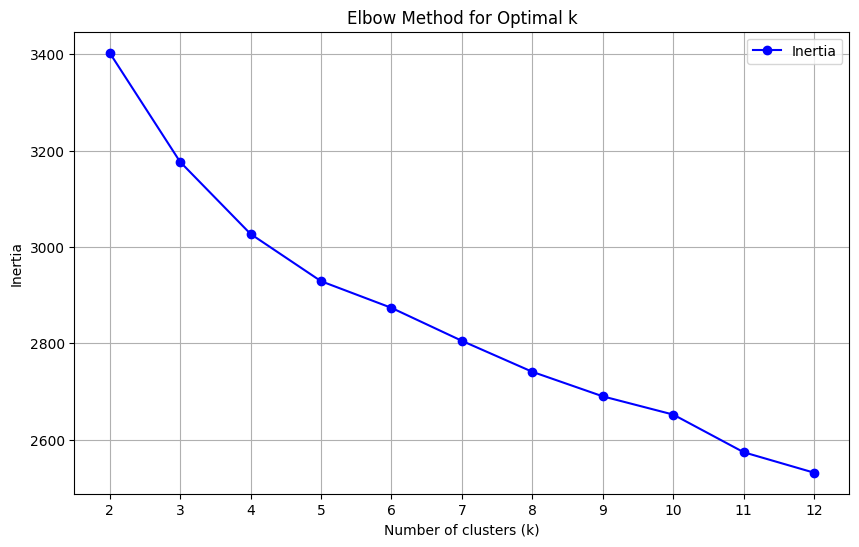

In [22]:
# Plotting the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(list(inertia_scores.keys()), list(inertia_scores.values()), marker='o', linestyle='-', color='b', label='Inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(2, 13))
plt.grid(True)
plt.legend()
plt.show()

Based on the inertia scores, the optimal number of clusters can be identified where the inertia value starts to decrease more slowly. Observing the inertia scores:

- From 2 to 3 clusters, the inertia decreases by about 226.
- From 3 to 4 clusters, the inertia decreases by about 150.
- From 4 to 5 clusters, the inertia decreases by about 98.
- From 5 to 6 clusters, the inertia decreases by about 55.

The rate of decrease starts to slow down significantly after 4 clusters. Hence, the Elbow Method suggests 4 clusters as optimal.

#### 4.5 Use the Silhouette method (by with showing the plot) to determine the optimal number of clusters. 
- HINT: This part is NOT about generating the silhouette analysis graphs. Instead, repeat the code in Step 4.4, but instead of using inertia values, use the silhouette scores that you have already saved from Step 4.3

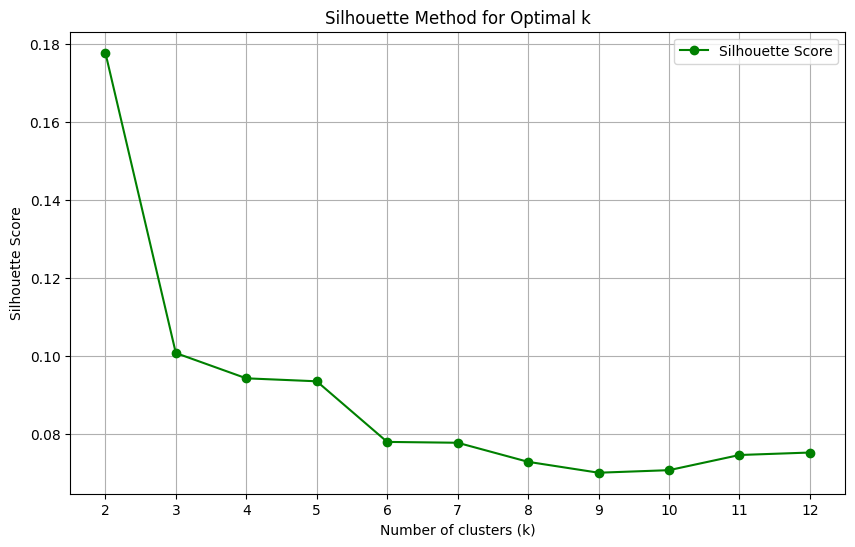

In [23]:
# Plotting the Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', linestyle='-', color='g', label='Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.xticks(range(2, 13))
plt.grid(True)
plt.legend()
plt.show()

Silhouette scores help determine the optimal number of clusters by measuring how similar an object is to its own cluster compared to other clusters:

- The highest silhouette score is for 2 clusters: 0.1777.
- The silhouette score drops significantly after 2 clusters, with values around 0.1 or lower for more clusters.

The Silhouette Score suggests 2 clusters as optimal since it has the highest value at 2 clusters.

#### 4.6 What can we summarize from the elbow and silhouette plots, and what is the optimal cluster number you would choose?

**Answer:**

**Summary from Elbow and Silhouette Plots**

**Elbow Plot:**

The Elbow Method suggests using 4 clusters as the optimal number. This is based on the point where the rate of decrease in inertia slows down significantly, indicating that adding more clusters beyond this point does not significantly reduce the inertia.

**Silhouette Plot:**

The Silhouette Scores suggest that 2 clusters are optimal, as the highest silhouette score is observed with 2 clusters. This indicates better-defined and more distinct clusters at this number.

**Optimal Number of Clusters:**

While the Elbow Method suggests 4 clusters, the Silhouette Score indicates 2 clusters. Given the trade-off between these two methods, a deeper understanding of the data and the specific business context might lean towards choosing 2 clusters due to the clearer separation between clusters. However, if you require more granularity, 4 clusters might also be considered optimal.

**Choosing the Optimal Cluster Number:**

**Considering both methods:**

- If you prioritize distinct and well-defined clusters, 2 clusters (based on Silhouette Scores) might be optimal.
- If you require more granularity and are comfortable with less distinct clusters, 4 clusters (based on Elbow Method) might be chosen.

___
## Step 5: Generating Cluster Labels [5 marks]

#### 5.1 Generate the predicted labels for each customer in the dataset, and save it the output array in a variable called `labels`.
- HINT: Use `fit_predict`

In [24]:
# optimal_k is the optimal number of clusters determined
optimal_k = 2

# Initialize KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)

# Fit KMeans and predict cluster labels
labels = kmeans.fit_predict(df_encoded)

# Check the shape of labels array (should match the number of samples)
print("Shape of labels array:", labels.shape)

Shape of labels array: (1000,)


#### 5.2 Append the `labels` array as a column (with the same name) to the processed dataframe from Step 3.6, so that each customer now has an assigned label.

In [25]:
# Convert labels array to DataFrame
labels_df = pd.DataFrame(labels, columns=['ClusterLabel_2'])

# Concatenate df_encoded and labels_df along columns axis
df_clustered = pd.concat([df_encoded, labels_df], axis=1)

# Display the updated DataFrame with cluster labels
df_clustered.head()

,Customer Age,Tenure,Balance Level,Customer Nationality_ALBANIA,Customer Nationality_ALGERIA,Customer Nationality_AUSTRALIA,Customer Nationality_BANGLADESH,Customer Nationality_BELGIUM,Customer Nationality_BOSNIA & HERZEGOVINA,Customer Nationality_BULGARIA,...,DC Spends_No Spends,SALARY_FLAG_Salary with Bank,SALARY_FLAG_Salary with Other Bank,DR_FLAG_Inactive DR,DR_FLAG_No DR,Bill Payment_Inactive Bill,Bill Payment_No Bill,CC Spends_Inactive CC,CC Spends_No CC,ClusterLabel_2
0,0.821429,0.900000,3,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,0.892857,0.250000,2,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,1
2,0.625000,0.650000,3,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
3,0.339286,0.516667,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0.642857,0.850000,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1


#### 5.3 Append the `labels` array as a column (with the same name) to the original dataset

In [26]:
# Append the cluster labels as a new column to the original dataset 'df'
df['Cluster_Labels_2'] = labels

# Display the updated DataFrame 'df' with cluster labels
df.head()

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance,Tenure,Balance Level,Cluster_Labels_2
0,353446,INDIA,67,2017-08-17,Active,No Salary,No DR,No Bill,No CC,1820.582258,54,3,0
1,99061,PHILIPPINES,71,2020-11-13,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387,15,2,1
2,344207,GREECE,56,2018-11-08,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000,39,3,0
3,496773,GHANA,40,2019-07-16,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000,31,1,1
4,39530,PHILIPPINES,57,2017-11-25,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839,51,2,1


**I will repeat steps 5.1 - 5.3 for an optimal cluster number of 4**

In [27]:
# Optimal number of clusters determined
optimal_k_4 = 4

# Initialize KMeans with optimal k
kmeans_4 = KMeans(n_clusters=optimal_k_4, random_state=0)

# Fit KMeans and predict cluster labels
labels_4 = kmeans_4.fit_predict(df_encoded)

# Check the shape of labels array (should match the number of samples)
print("Shape of labels array for 4 clusters:", labels_4.shape)

# Convert labels array to DataFrame
labels_df_4 = pd.DataFrame(labels_4, columns=['ClusterLabel_4'])

# Concatenate df_encoded and labels_df along columns axis
df_clustered_4 = pd.concat([df_encoded, labels_df_4], axis=1)

# Display the updated DataFrame with cluster labels
df_clustered_4.head()

# Append the cluster labels as a new column to the original dataset 'df'
df['Cluster_Labels_4'] = labels_4

# Display the updated DataFrame 'df' with cluster labels
df.head()


Shape of labels array for 4 clusters: (1000,)


,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance,Tenure,Balance Level,Cluster_Labels_2,Cluster_Labels_4
0,353446,INDIA,67,2017-08-17,Active,No Salary,No DR,No Bill,No CC,1820.582258,54,3,0,0
1,99061,PHILIPPINES,71,2020-11-13,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387,15,2,1,3
2,344207,GREECE,56,2018-11-08,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000,39,3,0,0
3,496773,GHANA,40,2019-07-16,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000,31,1,1,1
4,39530,PHILIPPINES,57,2017-11-25,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839,51,2,1,3


___
## Step 6: Extracting Insights from each Cluster [6 marks]
Now that we have assigned each customer to the relevant cluster labels, it is time to better understand how the clusters differ in terms of profile.

#### 6.1 Compare the customer ages across the clusters.
- HINT: Sample code: `df.groupby(['labels'])['Column name'].mean().round(2)`

In [28]:
# Calculate mean customer age for each cluster
mean_age_per_cluster_2 = df.groupby(['Cluster_Labels_2'])['Customer Age'].mean().round(2)

# Display the mean age per cluster
print("Mean Customer Age per Cluster with 2 optimal clusters:")
print(mean_age_per_cluster_2)

Mean Customer Age per Cluster with 2 optimal clusters:
Cluster_Labels_2
0    51.34
1    49.09
Name: Customer Age, dtype: float64


In [29]:
# Calculate mean customer age for each cluster
mean_age_per_cluster_4 = df.groupby(['Cluster_Labels_4'])['Customer Age'].mean().round(2)

# Display the mean age per cluster
print("Mean Customer Age per Cluster with 4 optimal clusters:")
print(mean_age_per_cluster_4)

Mean Customer Age per Cluster with 4 optimal clusters:
Cluster_Labels_4
0    51.34
1    48.03
2    49.06
3    50.44
Name: Customer Age, dtype: float64


**Mean Customer Age per Cluster:**

**2 Optimal Clusters:**
- **Cluster 0**: 51.34 years
- **Cluster 1**: 49.09 years

**4 Optimal Clusters:**
- **Cluster 0**: 51.34 years
- **Cluster 1**: 48.03 years
- **Cluster 2**: 49.06 years
- **Cluster 3**: 50.44 years

**Interpretation:**

For the 2-cluster solution, Cluster 0 has an older average age (51.34) compared to Cluster 1 (49.09). This suggests that customers in Cluster 0 are generally older than those in Cluster 1.

For the 4-cluster solution, the clusters are more granular. Cluster 0 remains the same with an average age of 51.34. Cluster 1 has a slightly younger average age of 48.03. Cluster 2 and Cluster 3 have average ages of 49.06 and 50.44, respectively. This breakdown provides a more detailed segmentation of customers based on age.

By examining other features similarly, we can build a comprehensive profile for each cluster, helping in targeted marketing, personalized services, or other strategic decisions.

#### 6.2 Compare the average monthly balance across the clusters.
- HINT: Use the right dataset that contains the column required

In [30]:
# Calculate average monthly balance for each cluster
avg_balance_per_cluster_2 = df.groupby(['Cluster_Labels_2'])['Monthly Average Balance'].mean().round(2)

# Display the average monthly balance per cluster
print("Average Monthly Balance per Cluster with 2 optimal clusters:")
print(avg_balance_per_cluster_2)

Average Monthly Balance per Cluster with 2 optimal clusters:
Cluster_Labels_2
0    15629.20
1      172.09
Name: Monthly Average Balance, dtype: float64


In [31]:
# Calculate average monthly balance for each cluster
avg_balance_per_cluster_4 = df.groupby(['Cluster_Labels_4'])['Monthly Average Balance'].mean().round(2)

# Display the average monthly balance per cluster
print("Average Monthly Balance per Cluster with 4 optimal clusters:")
print(avg_balance_per_cluster_4)

Average Monthly Balance per Cluster with 4 optimal clusters:
Cluster_Labels_4
0    15629.20
1      164.09
2      204.84
3      160.69
Name: Monthly Average Balance, dtype: float64


**Average Monthly Balance per Cluster:**

**2 Optimal Clusters:**
- **Cluster 0**: 15629.20
- **Cluster 1**: 172.09

**4 Optimal Clusters:**
- **Cluster 0**: 15629.20
- **Cluster 1**: 164.09
- **Cluster 2**: 204.84
- **Cluster 3**: 160.69

**Interpretation:**

For the 2-cluster solution, Cluster 0 has a significantly higher average monthly balance (15629.20) compared to Cluster 1 (172.09). This indicates that Cluster 0 consists of customers with much higher balances.

For the 4-cluster solution, the average monthly balance for Cluster 0 remains the same at 15629.20. Clusters 1, 2, and 3 have average balances of 164.09, 204.84, and 160.69, respectively. This provides a more detailed segmentation, showing finer distinctions among customers with lower average balances.

By examining additional features in a similar manner, we can build a comprehensive profile for each cluster, aiding in targeted marketing, personalized services, and other strategic decisions.


#### 6.3 Compare the tenure across the clusters.
- HINT: Use the right dataset that contains the column required

In [32]:
# Calculate average tenure for each cluster
avg_tenure_per_cluster_2 = df.groupby(['Cluster_Labels_2'])['Tenure'].mean().round(2)

# Display the average tenure per cluster
print("Average Tenure per Cluster per Cluster with 2 optimal clusters:")
print(avg_tenure_per_cluster_2)

Average Tenure per Cluster per Cluster with 2 optimal clusters:
Cluster_Labels_2
0    28.84
1    29.74
Name: Tenure, dtype: float64


In [33]:
# Calculate average tenure for each cluster
avg_tenure_per_cluster_4 = df.groupby(['Cluster_Labels_4'])['Tenure'].mean().round(2)

# Display the average tenure per cluster
print("Average Tenure per Cluster per Cluster with 4 optimal clusters:")
print(avg_tenure_per_cluster_4)

Average Tenure per Cluster per Cluster with 4 optimal clusters:
Cluster_Labels_4
0    28.84
1    28.83
2    32.21
3    29.28
Name: Tenure, dtype: float64


**Average Tenure per Cluster:**

**2 Optimal Clusters:**
- **Cluster 0**: 28.84 months
- **Cluster 1**: 29.74 months

**4 Optimal Clusters:**
- **Cluster 0**: 28.84 months
- **Cluster 1**: 28.83 months
- **Cluster 2**: 32.21 months
- **Cluster 3**: 29.28 months

**Interpretation:**

For the 2-cluster solution, the average tenure is very similar between the clusters, with Cluster 1 having a slightly longer average tenure (29.74 months) compared to Cluster 0 (28.84 months).

For the 4-cluster solution, Cluster 2 stands out with a significantly longer average tenure of 32.21 months. The other clusters have similar average tenures, with slight variations.

By examining additional features in a similar manner, we can build a comprehensive profile for each cluster, aiding in targeted marketing, personalized services, and other strategic decisions.


End of Document

___